### Import

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn import preprocessing
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.vq import vq



Loading data and selecting fraction/subset for training

In [2]:
data = pd.read_csv('./processed_data1.csv')
frac_data = data.sample(frac = 0.01) 


Data normalization and correlation matrix

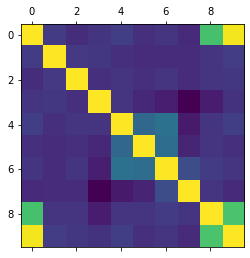

day   weekday      hour  event_type  product_id  \
day           1.000000  0.037015 -0.008959    0.012695    0.054183   
weekday       0.037015  1.000000  0.030829    0.024655   -0.004795   
hour         -0.008959  0.030829  1.000000   -0.002535    0.018458   
event_type    0.012695  0.024655 -0.002535    1.000000    0.017372   
product_id    0.054183 -0.004795  0.018458    0.017372    1.000000   
category_id  -0.001999 -0.014924 -0.003345   -0.029641    0.221230   
brand         0.011288 -0.015588  0.011570   -0.065698    0.270119   
price        -0.022391 -0.013087 -0.015384   -0.162888   -0.076729   
user_id       0.661638  0.013474  0.013081   -0.076333    0.018718   
user_session  0.979893  0.047159  0.025513    0.009715    0.051004   

              category_id     brand     price   user_id  user_session  
day             -0.001999  0.011288 -0.022391  0.661638      0.979893  
weekday         -0.014924 -0.015588 -0.013087  0.013474      0.047159  
hour            -0.003345  0.011

In [34]:
MEAN = data.mean()
STD = data.std()
normalized_data = (data - MEAN)/STD
normalized_frac_data = (frac_data - MEAN)/STD

correlation_matrix = normalized_frac_data.corr()

plt.matshow(correlation_matrix)
plt.show()
print(correlation_matrix)

PCA (not so successfull)

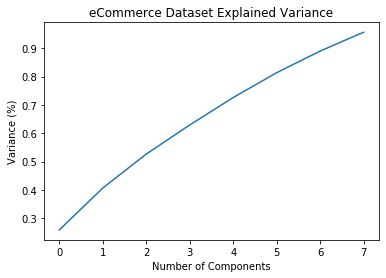

In [4]:
pca = PCA(random_state=1, n_components=8)
pca.fit(normalized_frac_data.values)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('eCommerce Dataset Explained Variance')
plt.show()

Plotting elbow curve for Kmeans algorithm

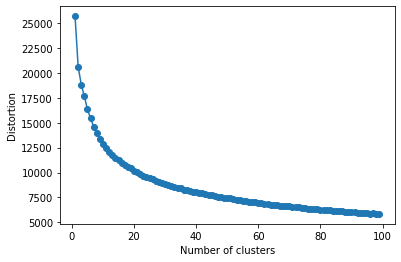

In [13]:
# calculate distortion for a range of number of cluster
max_clusters = 100
distortions = []
for i in range(1, max_clusters):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=1
    )
    km.fit(normalized_frac_data)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, max_clusters), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [4]:
# KMeans - normalized data

km_norm = KMeans(
    n_clusters=20, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
).fit(normalized_frac_data.values)


Method for cluster visualisation

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import cm

def plot_cluster(X: np.ndarray, cluster_labels: np.ndarray, centroids: np.ndarray):
    N = 100

    pca = PCA(random_state=1, n_components=3)
    CLUSTER_COUNT = np.max(np.unique(cluster_labels))
    X = pca.fit_transform(X)
    Xdf = pd.DataFrame(X)
    Xdf['cluster'] = cluster_labels

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    color=cm.rainbow(np.linspace(0,1,CLUSTER_COUNT))

    for i, c in zip(range(0, CLUSTER_COUNT), color):
        X_c = Xdf[Xdf['cluster'] == i].sample(n=N, random_state=0)
        xs = X_c.values[:, 0]
        ys = X_c.values[:, 1]
        zs = X_c.values[:, 2]
        ax.scatter(
            xs, ys, zs,
            s=50, c=[c],
            marker='o', edgecolor='black',
            label='cluster ' + str(i))

    centroid_pca = pca.transform(centroids)
    ax.scatter(centroid_pca[:, 0], centroid_pca[:, 1],  centroid_pca[:, 2],
        s=250, marker='*',
        c='red', edgecolor='black',
        label='centroids')

    plt.show()

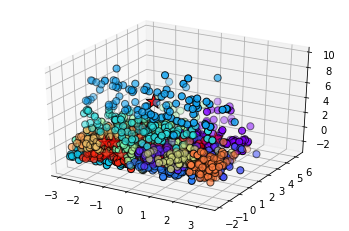

In [36]:
plot_cluster(normalized_frac_data.values, km_norm.labels_, km_norm.cluster_centers_)

DBSCAN algorithm

In [6]:
# DBSCAN - normalized data
db_scan_model = DBSCAN(eps=0.5, min_samples=11)
db_norm = db_scan_model.fit(normalized_frac_data.values)
print(np.unique(db_norm.labels_, return_counts=True))

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27], dtype=int64), array([26049,    39,    18,    28,    25,    11,    23,    17,    23,
          12,    11,    14,    24,    11,    13,    17,    13,    12,
          12,    18,    12,    11,    11,    13,    16,    11,    11,
          12,    11], dtype=int64))


Hierarchical clustering

In [7]:
# Hierarchical clustering

hierachical = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='ward')\
                    .fit_predict(normalized_frac_data.values)


MeanShift

In [8]:
# Bandwidth estimation for MeanShift

print(estimate_bandwidth(normalized_frac_data, n_jobs=-1))

3.668853018920747


In [14]:
# MeanShift

ms = MeanShift(n_jobs=-1).fit(normalized_frac_data.values)

print(np.unique(ms.labels_))


[0 1 2]


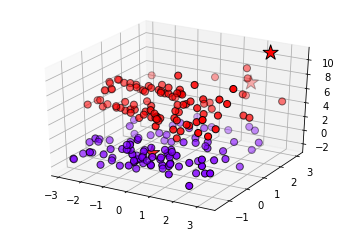

In [37]:
plot_cluster(normalized_frac_data.values, ms.labels_, ms.cluster_centers_)

In [16]:
print(np.unique(km_norm.labels_, return_counts=True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]), array([ 941, 1862, 1019, 2205,  240, 1389,  571,  987, 1804, 1665,  887,
       1418, 1721, 1839, 1769, 1179, 1122, 1405, 1472, 1003], dtype=int64))


Cluster evalutaion

In [17]:
# DAVIES BOULDIN Score

km_score_norm = davies_bouldin_score(normalized_frac_data.values, km_norm.labels_)
dbscan_score_norm = davies_bouldin_score(normalized_frac_data.values, db_norm.labels_)
hierachical_score = davies_bouldin_score(normalized_frac_data.values, hierachical)
ms_score_norm = davies_bouldin_score(normalized_frac_data.values, ms.labels_)

In [18]:
# print davies bouldin score
print("Scores davies bouldin:")
print(f'MeanShift    | {ms_score_norm}')
print(f'kMeans       | {km_score_norm}')
print(f'DBSCAN       | {dbscan_score_norm}')
print(f'hierarchical | {hierachical_score}')


Scores davies bouldin:
MeanShift    | 0.788744925258761
kMeans       | 1.6869679929013461
DBSCAN       | 1.3106421781818651
hierarchical | 1.9713260049288224


In [19]:
# SILHOUETTE Score

sil_km_score = silhouette_score(normalized_frac_data.values, km_norm.labels_)
sil_dbscan_score = silhouette_score(normalized_frac_data.values, db_norm.labels_)
sil_hierachical_score = silhouette_score(normalized_frac_data.values, hierachical)
sil_ms_score = silhouette_score(normalized_frac_data.values, ms.labels_)

In [20]:
# print silhouette score
print("Scores silhouette:")
print(f'MeanShift    |  {sil_ms_score}')
print(f'kMeans       |  {sil_km_score}')
print(f'hierarchical | {sil_hierachical_score}')
print(f'DBSCAN       | {sil_dbscan_score}')

Scores silhouette:
MeanShift    |  0.518316004315751
kMeans       |  0.11761998238861143
hierarchical | 0.06624802117418338
DBSCAN       | -0.42121663456460173


Correlation of cluster column with the rest

day   weekday      hour  event_type  product_id  \
day           1.000000  0.037015 -0.008959    0.012695    0.054183   
weekday       0.037015  1.000000  0.030829    0.024655   -0.004795   
hour         -0.008959  0.030829  1.000000   -0.002535    0.018458   
event_type    0.012695  0.024655 -0.002535    1.000000    0.017372   
product_id    0.054183 -0.004795  0.018458    0.017372    1.000000   
category_id  -0.001999 -0.014924 -0.003345   -0.029641    0.221230   
brand         0.011288 -0.015588  0.011570   -0.065698    0.270119   
price        -0.022391 -0.013087 -0.015384   -0.162888   -0.076729   
user_id       0.661638  0.013474  0.013081   -0.076333    0.018718   
user_session  0.979893  0.047159  0.025513    0.009715    0.051004   
cluster      -0.101715 -0.333429 -0.073107   -0.142183   -0.092159   

              category_id     brand     price   user_id  user_session  \
day             -0.001999  0.011288 -0.022391  0.661638      0.979893   
weekday         -0.014924 -0.015

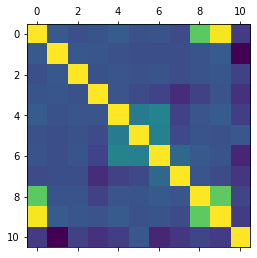

In [21]:
# Correlation of cluster column with the rest

corr_df = pd.DataFrame(normalized_frac_data)

corr_df["cluster"] = km_norm.labels_

new_correlation_matrix = corr_df.corr()
print(new_correlation_matrix)

plt.matshow(new_correlation_matrix)
plt.show()


Assigning rest of data to clusters

In [22]:
# assigning all the data to the clusters

def assign_cluster(observations: pd.DataFrame, centroids: pd.DataFrame):
    codes, distances = vq(observations.values, centroids.values)
    result = pd.DataFrame.copy(observations)
    result["cluster"] = codes
    return result

In [23]:
observations = pd.DataFrame.copy(normalized_data)
centroids = pd.DataFrame(km_norm.cluster_centers_)
observations = assign_cluster(observations, centroids)


In [24]:
# number of entities in each cluster
unique, counts = np.unique(observations["cluster"].values, return_counts=True)
print(unique, counts)
print(unique.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [ 90948 187519 102810 217610  22672 135813  57226  97160 180620 166271
  91810 147127 176361 184912 181045 117151 109577 134875 148479  99822]
(20,)


In [26]:
# denormalisation of data

def denormalize_data(df:pd.DataFrame, mean, std):
    return (df * std) + mean

Saving data with cluster column to new file

In [25]:
# writing processed data with cluster to CSV

data_with_cluster = pd.DataFrame.copy(data)
data_with_cluster["cluster"] = observations["cluster"]
data_with_cluster.to_csv("processed_data_with_cluster.csv", index=False)

Printing cluster statistics

In [27]:
def print_statistic(df: pd.DataFrame, cluster_value:int):
    dfc = df[df["cluster"] == cluster_value]
    event_types, event_ocurences = np.unique(dfc["event_type"].values, return_counts=True)
    print("event_type occurences")
    print(pd.DataFrame([event_ocurences], columns=event_types))
    brand_types, brand_occurences = np.unique(dfc["brand"].values, return_counts=True)
    brand_sorted = np.argsort(-brand_occurences)
    print("brand occurences")
    print(pd.DataFrame([brand_occurences[brand_sorted[0:5]]], columns=brand_types[brand_sorted[0:5]]))
    min_price = dfc["price"].min()
    average_price = dfc["price"].mean()
    max_price = dfc["price"].max()
    print(pd.DataFrame(data=[[min_price, average_price, max_price]], columns=["min", "average", "max"]))
    
    print("Price statistics on relation to event type")
    print(dfc[["event_type", "price"]].groupby(["event_type"]).agg(['min', 'mean', 'max', "count"]))

    print("Price statistics ")
    print(dfc[["brand", "price"]].groupby(["brand"]).agg(['min', 'mean', 'max', "count"]))


In [48]:
# run post processing to return values to original state with appended cluster column
clustered_data = pd.read_csv('./post_processed_data.csv')

sub_df = clustered_data[["event_type", "brand", "price", "cluster"]]
cluster_names = np.unique(sub_df["cluster"].values)
for i in cluster_names:
    print("Cluster " + str(i) + "\n")
    print_statistic(sub_df, i)
    print("\n\n")

77.780000  277.78    100
dorena    123.81  206.219636  297.14     55
entity    307.60  307.600000  307.60      1
irisk     144.76  144.760000  144.76    203
kosmekka  124.60  150.342690  150.79   1171
marathon  130.89  135.998831  137.78   6544
masura    126.97  126.970000  126.97      1
runail    155.83  175.865479  184.13    480
sanoto    117.46  138.424167  157.14    396
shik      131.19  145.914336  179.05    828
solomeya  133.33  133.499596  133.56     99
strong    148.57  198.908754  327.78  12794



Cluster 5

event_type occurences
   purchase  remove_from_cart
0     25415            110398
brand occurences
   runail  irisk  masura  grattol  bpw.style
0   18183  14545   14448    10887       8109
    min   average    max
0  0.06  4.395858  78.57
Price statistics on relation to event type
                 price                         
                   min      mean    max   count
event_type                                     
purchase          0.06  4.146173  63.33   25415
rem